# Development: Train 3-Category Classifier
Use the latest and greatest model structures, parameters, workflow (ie class weighting, learning fast & slow, etc) to train a 3-category classifier using only the non-road training samples.

This is the latest version as of the start of Phase IV, meant to leverage the previous changes in order to utilize the `fit_generator`.

Date: 2019-02-01  
Author: Peter Kerins  

## Preparation

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt

import pandas as pd

import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Add, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

import collections
from pprint import pprint

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow
import util_chips
import util_training
import util_network
import util_scoring
from batch_generator import BatchGenerator


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
data_root='/data/phase_iv/'

tile_resolution = 5
tile_size = 256
tile_pad = 32
resolution=tile_resolution  # Lx:15 S2:10

processing_level = None
source = 's2'
#image_suffix = 'E'

s2_bands=['blue','green','red','nir','swir1','swir2','alpha']; s2_suffix='BGRNS1S2A'  # S2, Lx

s1_bands=['vv','vh']; s1_suffix='VVVH'  

resampling='bilinear'
processing = None

label_suffix = 'aue'
label_lot = '0'

# can do much more sophisticated filtering than this, but fine for demonstration
place_images = {}
place_images['sitapur']=['E']


### Specify training data & training parameters

In [3]:
window = 17

# bands stuff outdated! needs to be reconciled with catalog filtering
# will ignore for the moment since this is a bigger fix...
# haven't done any examples yet incorporating additional chips beyond s2
# into construction of a training sample
bands_vir=s2_bands[:-1]
bands_sar=None
bands_ndvi=None
bands_ndbi=None
bands_osm=None

# this can get updated when cloudmasking is added
haze_removal = False

epochs = 500 # this is fine, if irrelevant
batch_size = 128
balancing = None

In [4]:
# needs to be updated completely; bands stuff doesn't make sense right now
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir 6


In [5]:
#alternative workflow

In [6]:
# skip training data superset
# for just this moment, skip the scaling/normalization
# still need to remap lulc target data! (first, to consolidated cats; second, to 0,1,2,3..)
# for 3category, remove roads -> done at catalog level
# change target data to onehot (presumably)
# generate weighting information -> from already filtered catalog/dataframe
# create callbacks
# build model
# compile model
# train with fit_generator
# evaluate performance -> apply to validation dataset!
# score & record

### Specify data of interest
Load and manipulate the catalog to specify which samples are of interest for this training.

In [7]:
df = util_chips.load_catalog()
print len(df.index)

1898061


In [8]:
mask = pd.Series(data=np.zeros(len(df.index),dtype='uint8'), index=range(len(df)), dtype='uint8')

for place,image_list in place_images.iteritems():
    for image in image_list:
        mask |= (df['city']==place) & (df['image']==image)

# straight away remove road samples
mask &= (df['lulc']!=6)

# filter others according to specifications
mask &= (df['gt_type']==label_suffix)
mask &= (df['gt_lot']==int(label_lot))
mask &= (df['source']==source)
mask &= (df['resolution']==int(resolution))
mask &= (df['resampling']==resampling)
mask &= (df['processing']==str(processing).lower())

print np.sum(mask)

154829


In [9]:
#here for example we will just exclude all roads samples
df = df[mask]
len(df)

154829

#### Split data (ie catalogs) into training and validation tranches

In [10]:
df_t,df_v = util_chips.split_catalog_by_locale(df)
print len(df_t), len(df_v)
assert len(df_t)+len(df_v)==len(df)

105781 49048


## Training

### Build loss function

#### Inspect dataframes for consistency

In [11]:
print util_training.calc_category_counts(df_t,remapping=None), len(df_t)
print util_training.calc_category_counts(df_v,remapping=None), len(df_v)
print
print util_training.calc_category_counts(df,remapping=None), len(df)

{0: 47311, 1: 17177, 2: 11524, 3: 28026, 4: 1703, 5: 40} 105781
{0: 23426, 1: 8422, 2: 4109, 3: 12519, 4: 166, 5: 406} 49048

{0: 70737, 1: 25599, 2: 15633, 3: 40545, 4: 1869, 5: 446} 154829


#### Generate class weighting information

In [12]:
category_weights =  util_training.generate_category_weights(df,remapping='standard',log=False,mu=1.0,max_score=None)

In [13]:
print category_weights.items()
weights = list(zip(*category_weights.items())[1])
print weights

[(0, 1.0), (1, 2.76327200281261), (2, 1.2093241926384355)]
[1.0, 2.76327200281261, 1.2093241926384355]


#### Use weights to make weighted categorical crossentropy loss function

In [14]:
loss = util_training.make_loss_function_wcc(weights)

### Build convolutional neural network

#### Name and briefly describe model

In [15]:
model_id = '3cat_Sit_gen-test'
notes = 'new architecture: sitapur E only, 3cat 5m bilinear, no processing'

In [16]:
print("DEFAULT:",K.image_data_format())
K.set_image_data_format('channels_first')
print("UPDATED:",K.image_data_format())

('DEFAULT:', 'channels_last')
('UPDATED:', 'channels_first')


#### Create actual model

In [17]:
#hardcoded params
network=util_network.build_model(util_network.doubleres_block,input_shape=(6,17,17),output_nodes=3)
util_network.compile_network(network, loss, LR=0.001)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 17, 17)   4832        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 17, 17)   1760        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 17, 17)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

---

### Train model fast

#### Create generators to provide training samples

In [18]:
generator_t = BatchGenerator(df_t,remapping='3cat',look_window=window,batch_size=batch_size)
generator_v = BatchGenerator(df_v,remapping='3cat',look_window=window,batch_size=batch_size)

#### Create callback functions for training

In [19]:
weights_label='weights_fast'
callbacks, weights_path = util_training.create_callbacks(data_root, model_id, weights_label=weights_label, patience=1)

#### Conduct training using `fit_generator` and visualize progress

Epoch 1/500
827/827 [==============================] - 197s 239ms/step - loss: 0.9228 - acc: 0.7275 - val_loss: 1.3303 - val_acc: 0.6863
Epoch 2/500
827/827 [==============================] - 130s 157ms/step - loss: 0.6414 - acc: 0.8196 - val_loss: 1.2970 - val_acc: 0.6998
Epoch 3/500
827/827 [==============================] - 97s 117ms/step - loss: 0.4965 - acc: 0.8622 - val_loss: 1.5203 - val_acc: 0.7085


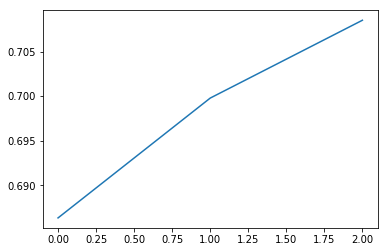

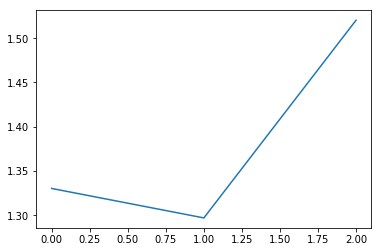

In [20]:
# train fast
#history_fast = network.fit(X_train, Y_t_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_v_cat), shuffle=True,callbacks=callbacks)
#docs: fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None,
                    #class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
history_fast = network.fit_generator(generator_t, epochs=epochs, callbacks=callbacks, steps_per_epoch=generator_t.steps,
                                    validation_data=generator_v, validation_steps=generator_v.steps,
                                    shuffle=True,use_multiprocessing=True,max_queue_size=40,workers=64,)

plt.plot(history_fast.history['val_acc'])
plt.show()
plt.plot(history_fast.history['val_loss'])
plt.show()

---

### Rebuild model and train slow

In [21]:
#hardcoded params
network=util_network.build_model(util_network.doubleres_block,input_shape=(6,17,17),output_nodes=3)
# load weights from fast learning
network.load_weights(weights_path)

util_network.compile_network(network, loss, LR=0.0001)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 6, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 17, 17)   4832        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 17, 17)   1760        input_2[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 17, 17)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

#### Create generators to provide training samples

In [22]:
generator_t.reset()
generator_v.reset()

#### Create callback functions for training

In [23]:
weights_label='weights_slow'
callbacks, weights_path = util_training.create_callbacks(data_root, model_id, weights_label=weights_label, patience=5)

#### Conduct training using `fit_generator` and visualize progress

Epoch 1/500
827/827 [==============================] - 93s 113ms/step - loss: 0.4798 - acc: 0.8661 - val_loss: 1.3407 - val_acc: 0.7161
Epoch 2/500
827/827 [==============================] - 76s 92ms/step - loss: 0.4478 - acc: 0.8748 - val_loss: 1.3754 - val_acc: 0.7045
Epoch 3/500
827/827 [==============================] - 116s 141ms/step - loss: 0.4232 - acc: 0.8814 - val_loss: 1.4266 - val_acc: 0.7005
Epoch 4/500
827/827 [==============================] - 88s 106ms/step - loss: 0.4013 - acc: 0.8879 - val_loss: 1.4569 - val_acc: 0.7020
Epoch 5/500
827/827 [==============================] - 117s 141ms/step - loss: 0.3815 - acc: 0.8930 - val_loss: 1.4991 - val_acc: 0.7101


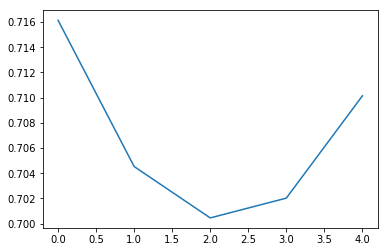

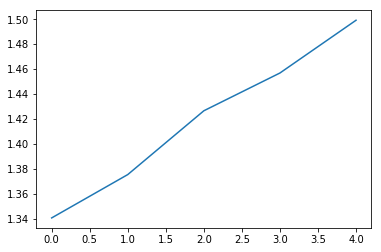

In [24]:
history_slow = network.fit_generator(generator_t, epochs=epochs, callbacks=callbacks, steps_per_epoch=generator_t.steps,
                                    validation_data=generator_v, validation_steps=generator_v.steps,
                                    shuffle=True,use_multiprocessing=True,max_queue_size=40,workers=64,)

plt.plot(history_slow.history['val_acc'])
plt.show()
plt.plot(history_slow.history['val_loss'])
plt.show()

---

## Scoring

In [25]:
# reset validation generator
# preallocate empty Y and Yhat storage vectors based on total size of validation dataset
# batch by batch:
# -> two ways to go: store complete Y and Yhat, or store and add/append confusion matrices
# size shouldnt really be a constraint for two 1D integer arrays of arbitrary length
# apply model to batch X vector
# store model output Y_hat
# store true output Y (after from_categorical - basically same process as Yhat_prob -> Yhat)
# compare and score resulting vectors like normal

# note:
# or i'm an idiot and this already exists within keras, obviously

### Apply model to training and validation data

In [26]:
generator_t.reset()
#predict_generator(generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
predictions_t = network.predict_generator(generator_t, steps=generator_t.steps, verbose=1,
                  use_multiprocessing=True, max_queue_size=40, workers=64,)
print predictions_t.shape

generator_v.reset()
#predict_generator(generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
predictions_v = network.predict_generator(generator_v, steps=generator_v.steps, verbose=1,
                  use_multiprocessing=True, max_queue_size=40, workers=64,)
print predictions_v.shape

827/827 [==============================] - 68s 83ms/step
(105781, 3)
384/384 [==============================] - 23s 61ms/step
(49048, 3)


In [27]:
Yhat_t = predictions_t.argmax(axis=-1)
print Yhat_t.shape
Yhat_v = predictions_v.argmax(axis=-1)
print Yhat_v.shape

(105781,)
(49048,)


### Extract corresponding _actual_ ground-truth values directly from catalog

In [28]:
Y_t = generator_t.get_label_series().values
print Y_t.shape
Y_v = generator_v.get_label_series().values
print Y_v.shape

(105781,)
(49048,)


### Generate typical scoring information

In [29]:
print "evaluate training"
# hardcoded categories
categories=[0,1,2]
train_confusion = util_scoring.calc_confusion(Yhat_t,Y_t,categories)
train_recalls, train_precisions, train_accuracy = util_scoring.calc_confusion_details(train_confusion)

# Calculate f-score
beta = 2
train_f_score = (beta**2 + 1) * train_precisions * train_recalls / ( (beta**2 * train_precisions) + train_recalls )
train_f_score_open = train_f_score[0] 
train_f_score_nonres = train_f_score[1]  
train_f_score_res = train_f_score[2]  
train_f_score_roads = None#train_f_score[3]  
train_f_score_average = np.mean(train_f_score)

evaluate training
0 47311
1 17177
2 41293
[[42339  1940  3032]
 [  665 15183  1329]
 [ 1175  1004 39114]]
105781 96636 0.9135478015900776


In [30]:
print "evaluate validation"
valid_confusion = util_scoring.calc_confusion(Yhat_v,Y_v,categories)
valid_recalls, valid_precisions, valid_accuracy = util_scoring.calc_confusion_details(valid_confusion)

# Calculate f-score
valid_f_score = (beta**2 + 1) * valid_precisions * valid_recalls / ( (beta**2 * valid_precisions) + valid_recalls )
valid_f_score_open = valid_f_score[0] 
valid_f_score_nonres = valid_f_score[1] 
valid_f_score_res = valid_f_score[2] 
valid_f_score_roads = None# valid_f_score[3] 
valid_f_score_average = np.mean(valid_f_score)

evaluate validation
0 23426
1 8422
2 17200
[[16902  3105  3419]
 [ 2084  3670  2668]
 [ 1498  1443 14259]]
49048 34831 0.710141086282825


In [31]:
# expanding lists to match expected model_record stuff
train_recalls_expanded = [train_recalls[0],train_recalls[1],train_recalls[2],None]
valid_recalls_expanded = [valid_recalls[0],valid_recalls[1],valid_recalls[2],None]
train_precisions_expanded = [train_precisions[0],train_precisions[1],train_precisions[2],None]
valid_precisions_expanded = [valid_precisions[0],valid_precisions[1],valid_precisions[2],None]

### Record experiment configuration and results

In [42]:
reload(util_scoring)
#scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
#model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
network_filename = data_root+'models/'+model_id+'.hd5'

#if os.path.exists(scaler_filename):
#    print 'Aborting all pickle operations: file already exists at specified path ('+scaler_filename+')'
#elif os.path.exists(model_filename):
#    print 'Aborting all pickle operations: file already exists at specified path ('+model_filename+')'
if os.path.exists(network_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+network_filename+')'
else:
    #print scaler_filename
#    print model_filename
    print network_filename
    #pickle.dump(scaler, open(scaler_filename, 'wb'))
#    pickle.dump(model, open(model_filename, 'wb'))
    network.save(network_filename)
    # tracking only occurs if all saves are successful
    util_scoring.record_model_creation(
        model_id, notes, place_images, label_suffix+label_lot, resolution, stack_label, feature_count, 
        window, generator_t.remapping, balancing, 
        network.get_config(), epochs, batch_size,
        train_confusion, train_recalls_expanded, train_precisions_expanded, train_accuracy,
        train_f_score_open, train_f_score_nonres, train_f_score_res, train_f_score_roads, train_f_score_average,
        valid_confusion, valid_recalls_expanded, valid_precisions_expanded, valid_accuracy,
        valid_f_score_open, valid_f_score_nonres, valid_f_score_res, valid_f_score_roads, valid_f_score_average,)

/data/phase_iv/models/3cat_Sit_gen-test.hd5
model scorecard updated


---